# TRI-MODEL WITH SHARED TAK1

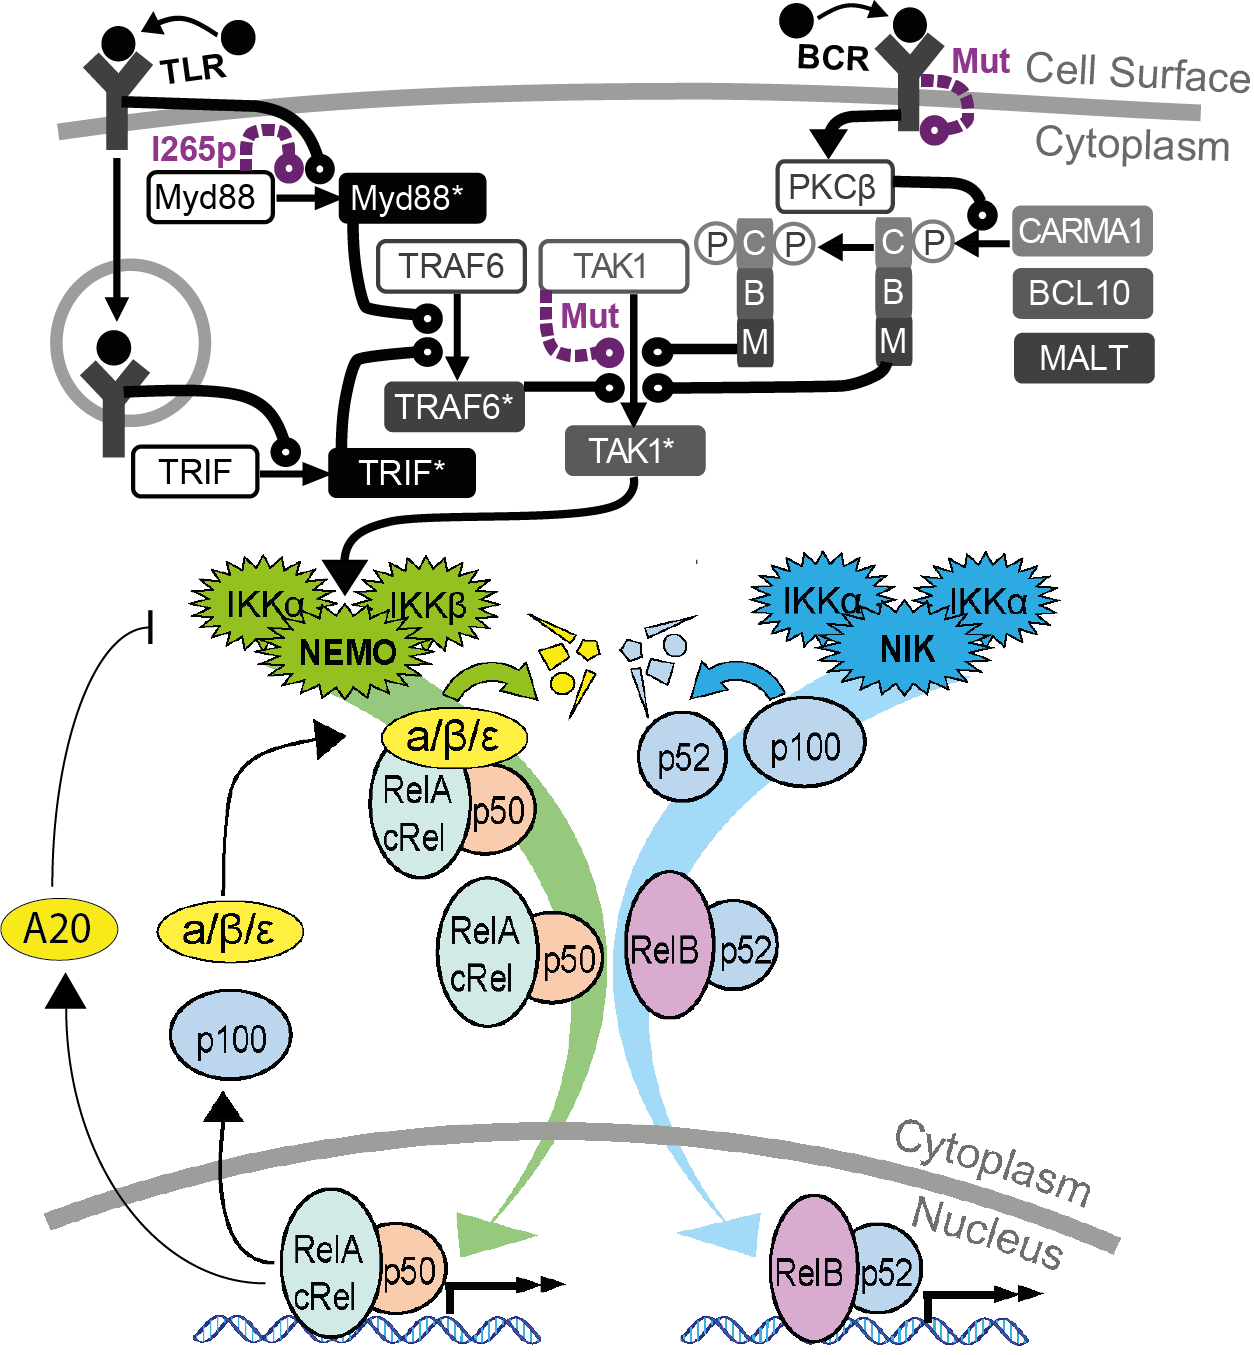

In [65]:
display("image/png", read("triModelA20Diagram.png"))

In [ ]:
###########################################################################
### File locations  ######################################################
###########################################################################
### set up where CSV2Julia is
locationOfCSV2Julia="csv2Julia/csv2model-multiscale.py"
#we use the same initial conditions at the PNAS paper 2019 Mitchell Roy et al.
fullModelInitFile="initialConditions/fullModelInits.csv"
moduleDefinitionFilesFolder="moduleDefinitionFiles/"
locationOfFixSpexies="utilityFunctions/"

In [ ]:
#packages we need
using DifferentialEquations
using Plots 
using Pkg
# Pkg.add(Pkg.PackageSpec(;name="Parsers", version="2.2.4"))
using CSV
using DataFrames
using JLD2
using FileIO
using StatsPlots
using Plots.PlotMeasures

delay=false

In [ ]:
include("combineModels.jl")
combinedModelLocation=combineModels(["BCR","TLR","NFkB"])

In [ ]:
include("generateModel.jl")

In [ ]:
include("defineInputs.jl")

#bcrSignalSS
#bcrSignalSSHigh
#tlrSignalSS
#bcrSignalTC
#tlrSignalTC
#nikSignalSS
#nikSignalTC

t=0
include("distributedModelFiles/odeModel.jl")
include("variableNames.jl")
include("scanIncludes.jl")

include("runSimulation.jl")
include("plotAllSpecies.jl")
colorArray=palette(:seaborn_colorblind)

first_cell=1
last_cell=1
preCV=0.11
maxTimeTC=12*60
maxTimeSS=1000*60

In [ ]:
conditions=[]
paramsToChange=[]
modifyAmount=[]
BCRSSArray=[]
BCRTCArray=[]
TLRSSArray=[]
TLRTCArray=[]
NIKSSArray=[]
NIKTCArray=[]

#M-CLL
push!(conditions,"M-CLL CpG")
push!(paramsToChange,["k1_MYD88SELFACTIVATION-TLR"])
push!(modifyAmount,[0.0])
push!(BCRSSArray,bcrSignalSS)
push!(BCRTCArray,bcrSignalSS)
push!(TLRSSArray,tlrSignalSS)
push!(TLRTCArray,tlrSignalTC)
push!(NIKSSArray,nikSignalSS)
push!(NIKTCArray,nikSignalSS)

#U-CLL
push!(conditions,"U-CLL CpG")
push!(paramsToChange,["k1_MYD88SELFACTIVATION-TLR"])
push!(modifyAmount,[0.0])
push!(BCRSSArray,bcrSignalSSHigh)
push!(BCRTCArray,bcrSignalSSHigh)
push!(TLRSSArray,tlrSignalSS)
push!(TLRTCArray,tlrSignalTC)
push!(NIKSSArray,nikSignalSS)
push!(NIKTCArray,nikSignalSS)


println("Summary of conditions being run:")
folder="teachingOutputs"
show(IOContext(stdout, :limit => false), "text/plain", hcat(conditions,paramsToChange,modifyAmount))

In [ ]:
runSimulation(first_cell,last_cell,conditions,folder,BCRSSArray,BCRTCArray,TLRSSArray,TLRTCArray,NIKSSArray,NIKTCArray)

In [ ]:
hoursToPlot=12
colorArray=palette(:seaborn_colorblind)

speciesToPlot=syms
maxValOfYAxis=0

speciesToPlot=["RelAnp50n","cRelnp50n","RelBnp52n"]
qualityScaling=0.5
#let't plot!
gr()
plotAllSpecies(speciesToPlot,conditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling,60)

# Now run your own simulations

In [ ]:
conditions=[]
paramsToChange=[]
modifyAmount=[]
BCRSSArray=[]
BCRTCArray=[]
TLRSSArray=[]
TLRTCArray=[]
NIKSSArray=[]
NIKTCArray=[]

#healthy
push!(conditions,"WT")
push!(paramsToChange,["k1_MYD88SELFACTIVATION-TLR"])
push!(modifyAmount,[0.0])
push!(BCRSSArray,bcrSignalSS)
push!(BCRTCArray,bcrSignalSS)
push!(TLRSSArray,tlrSignalSS)
push!(TLRTCArray,tlrSignalTC)
push!(NIKSSArray,nikSignalSS)
push!(NIKTCArray,nikSignalSS)

#cancer
push!(conditions,"myd88 l265p")
push!(paramsToChange,["k1_MYD88SELFACTIVATION-TLR"])
push!(modifyAmount,[1.0])
push!(BCRSSArray,bcrSignalSSHigh)
push!(BCRTCArray,bcrSignalSSHigh)
push!(TLRSSArray,tlrSignalSS)
push!(TLRTCArray,tlrSignalTC)
push!(NIKSSArray,nikSignalSS)
push!(NIKTCArray,nikSignalSS)


# example Druggable parameters:
# "k1_IKKdeactivation-linking" = IKK inhibitors
# "k1_NIKSynth-NFkB" = NIK inhibitors
# "k1_RelASynth-NFkB" = RELA inhibtors
# "basal_p50Synth-NFkB" = p50 inhibitors
# "basal_cRelSynth-NFkB" = cRel inhibitors
# "k1_CpBS-BCR" = BTK inhibitor (BCR)
# "k1_IKKKdeactivation-TLR" = TRAF6 inhibitors
# "k1_IkBaSynth-NFkB" = IkBa inhibitors

#cancer + drug
push!(conditions,"myd88 l265p + drug")
push!(paramsToChange,["k1_MYD88SELFACTIVATION-TLR","k1_IkBaSynth-NFkB"])
push!(modifyAmount,[1.0,10.0])
push!(BCRSSArray,bcrSignalSSHigh)
push!(BCRTCArray,bcrSignalSSHigh)
push!(TLRSSArray,tlrSignalSS)
push!(TLRTCArray,tlrSignalTC)
push!(NIKSSArray,nikSignalSS)
push!(NIKTCArray,nikSignalSS)


println("Summary of conditions being run:")
folder="teachingOutputs"
show(IOContext(stdout, :limit => false), "text/plain", hcat(conditions,paramsToChange,modifyAmount))

In [ ]:
runSimulation(first_cell,last_cell,conditions,folder,BCRSSArray,BCRTCArray,TLRSSArray,TLRTCArray,NIKSSArray,NIKTCArray)

In [ ]:
hoursToPlot=12
colorArray=palette(:seaborn_colorblind)

speciesToPlot=syms
maxValOfYAxis=0

speciesToPlot=["RelAnp50n","cRelnp50n","RelBnp52n"]
qualityScaling=0.5
#let't plot!
gr()
plotAllSpecies(speciesToPlot,conditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling,60)